# INITIAL ASSESSMENT FOR DERIVATIVES STRATEGY CANDIDATES

### Jiaxi Wang

### PYTHON ASSESSMENT

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# if jupyterthemes is installed we can easilly have pretty plot
try:
    from jupyterthemes import jtplot
    # choose which theme to inherit plotting style from
    # onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
    jtplot.style(theme='solarizedl', ticks=True, grid=True, figsize=(12, 8), context='talk')
except:
    print('Use default plot theme')


Use default plot theme


In [49]:
# Load data from excel file
transactions = pd.read_excel('./stock_trading.xlsx', sheetname='Transactions', index_col=1)
prices = pd.read_excel('./stock_trading.xlsx', sheetname='Prices', index_col=0)

# Cut columns, delete 'US Equity'
prices.columns = [colname.split()[0] for colname in prices.columns.tolist()]

In [3]:
# Sanity check
print('# of duplicated index in prices:', sum(prices.index.duplicated()))
print('# of duplicated index in transactions:', sum(transactions.index.duplicated()))
print('All transaction date can be found in prices:', transactions.index.isin(prices.index).all())
print('All stock name can be found in price data:', transactions['Ticker'].isin(prices.columns).all())
# prices.head()
# transactions.head()

# of duplicated index in prices: 0
# of duplicated index in transactions: 0
All transaction date can be found in prices: True
All stock name can be found in price data: True


In [4]:
# Naive way to run tally
def naive(transactions, prices):
    cur_position  = { ticker : 0 for ticker in prices.columns}
    cur_cost      = { ticker : 0 for ticker in prices.columns}
    hist_position = []
    hist_cost     = []
    
    # construct position from trasactions
    for row in transactions.itertuples():
        # example: Pandas(Index=Timestamp('2017-01-05 00:00:00'), Ticker='FB', Quantity=-2600, Price=116.87)
        pos, cost = cur_position[row[1]], cur_cost[row[1]]
        cost += row[2] * row[3]
        pos += row[2]
        cur_position[row[1]], cur_cost[row[1]] = pos, cost
        hist_position.append(cur_position.copy())
        hist_cost.append(cur_cost.copy())

    df_position = pd.DataFrame(hist_position, index=transactions.index)\
                    .reindex(prices.index)\
                    .fillna(method='pad')
    df_cost     = pd.DataFrame(hist_cost, index=transactions.index)\
                    .reindex(prices.index)\
                    .fillna(method='pad')
    df_close    = df_position.multiply(prices).fillna(method='pad')
    df_pnl      = df_close - df_cost
    return df_pnl

# Using pivot operation to run tally
def pivot(transactions, prices):
    # Quantity
    q = transactions.pivot(columns='Ticker', values='Quantity')\
                    .reindex(prices.index)\
                    .fillna(0)
    # Price
    p = transactions.pivot(columns='Ticker', values='Price')\
                    .reindex(prices.index)\
                    .fillna(0)
    cost = (q*p).cumsum(axis=0)
    # position value from close price
    close = (q.cumsum(axis=0)*prices)
    pnl = (close-cost)
    return pnl

I have implemented two methods to run the tally. In the given data set, the naive way is faster. However, the performance depends on the size of the data set.

In [5]:
%timeit naive(transactions, prices)
%timeit pivot(transactions, prices)

100 loops, best of 3: 7.96 ms per loop
100 loops, best of 3: 7.52 ms per loop


In [52]:
pnl

,AAPL,AMZN,FB,GOOGL,MSFT,NFLX,NVDA
date,,,,,,,
2017-01-03,0.00,NaN,0.0,0.0,2001.12,0.0,0.00
2017-01-04,0.00,NaN,0.0,0.0,193.38,0.0,0.00
2017-01-05,0.00,NaN,-9880.0,0.0,193.38,0.0,0.00
2017-01-06,0.00,NaN,-17004.0,0.0,3679.50,0.0,0.00
2017-01-09,0.00,NaN,-20878.0,0.0,2388.54,0.0,0.00
2017-01-10,0.00,NaN,-19448.0,0.0,2259.18,0.0,0.00
2017-01-11,0.00,NaN,-23972.0,0.0,5939.34,0.0,0.00
2017-01-12,0.00,NaN,-25350.0,0.0,2194.50,0.0,-3551.52
2017-01-13,0.00,NaN,-29822.0,0.0,2775.96,0.0,-3599.04


In [6]:
def answer(pnl):
    def millions(x, pos):
        'The two args are the value and tick position'
        return '$%1.1fM' % (x*1e-6)

    formatter = FuncFormatter(millions)
    ax = pnl.plot(alpha=0.7, ls='--')
    port_pnl = pnl.sum(axis=1)
    port_pnl.plot(lw=3, label='Portfolio')
    ax.yaxis.set_major_formatter(formatter)
    ax.set_xlabel('Date')
    ax.set_ylabel('P&L')
    ax.legend()
    print('The portfolio final P&L is ', '${:,.2f}'.format(port_pnl[-1]))
    print('The average transaction size is ', '${:,.2f}'.format(np.mean(abs(transactions['Quantity'] * transactions['Price']))))
    print('The contribution to final P&L is')
    print(pnl.loc[pnl.index[-1]].T.sort_values().map('${:,.2f}'.format))

In [59]:
pnl.loc[pnl.index[-1]].T.sort_values().map('${:,.2f}'.format)

GOOGL    $-123,310.00
NFLX     $-118,253.00
FB          $8,981.00
AAPL      $199,583.00
MSFT      $398,329.00
NVDA      $838,014.00
AMZN             $nan
Name: 2017-11-17 00:00:00, dtype: object

The portfolio final P&L is  $1,203,344.00
The average transaction size is  $287,390.40
The contribution to final P&L is
GOOGL    $-123,310.00
NFLX     $-118,253.00
AMZN            $0.00
FB          $8,981.00
AAPL      $199,583.00
MSFT      $398,329.00
NVDA      $838,014.00
Name: 2017-11-17 00:00:00, dtype: object


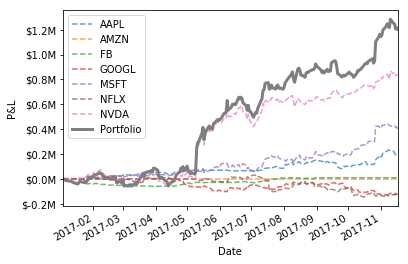

In [7]:
answer(naive(transactions, prices))

From the above contribution to final PnL, we can see that Google accounted fro the biggest share of losses and Nvidia accounts for the biggest share of profits.